In [1]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os,glob, socket
import tifffile as tif
from skimage.filters import rank
from skimage.morphology import disk
import time,pickle
from funciones_wake import *
import funciones_wake
from scipy.ndimage import rotate





In [2]:
class wakeflex():
    def __init__(self,t,L):
        rho  = 1.2
        nu = 15e-6
        D = 5e-2
        Lspan = 35e-2
        Sf = Lspan*D

        scale_force = 1/241  # de gramo a newton  

        rho_50 = 1305 # valores en kg/m3
        rho_75 = 1902
        y1_50 = 37  #valores en mm
        y1_75 = 50 
        D = 5e-2
        
        if t == 50:
            self.y1 = y1_50
            self.rhom = rho_50
        elif t == 75:
            self.y1 = y1_75
            self.rhom = rho_75
        self.t = t
        self.L = L
        self.Lr = L*D
        self.B = B_flexion(self.y1,self.rhom,self.t)
        self.modo_elastico = 0
        self.BnL  = beta_nL(self.modo_elastico)
        self.freqn = freq_elast (self.BnL,self.Lr,self.B,self.rhom,self.t)
        
    def modo_elastico_i(self,i):
        self.modo_elastico = i
        self.BnL  = beta_nL(self.modo_elastico)
        self.freqn = freq_elast (self.BnL,self.Lr,self.B,self.rhom,self.t)
        
        
    
    

In [3]:


def plot_displacement(filei):
    file_aux = open(filei, 'rb')
    data = pickle.load(file_aux)
    fig,ax = plt.subplots(1,2)
    ax0,ax1 = ax
    ax0.contourf(data.std)


    ax1.contourf(data.std_rot)


    for i,xi in enumerate(data.complex_num_0):
        xi0,xi1 = [np.real(xi),np.imag(xi)]
        ax0.plot(xi0,xi1,'wo')
        xi2 = [np.real(data.complex_num_0_rot[i]),np.imag(data.complex_num_0_rot[i])]
        ax1.plot(xi2[0],xi2[1],'ys')
        data.complex_num_0_rot[i]  = xi2[0] + xi2[1]*1j
    for i,xi in enumerate(data.complex_num_1):
        xi0,xi1 = [np.real(xi),np.imag(xi)]
        ax0.plot(xi0,xi1,'wo',fillstyle='none')
        xi2 = [np.real(data.complex_num_1_rot[i]),np.imag(data.complex_num_1_rot[i])]
        ax1.plot(xi2[0],xi2[1],'rs')   
        data.complex_num_1_rot[i]  = xi2[0] + xi2[1]*1j  

def corrige_rotacion(lista_objs):
    
    for i,filei in enumerate(lista_objs):

        file_aux = open(filei, 'rb')
        data = pickle.load(file_aux)
        za1,za2,zb,zc,zd1,zd2 = data.complex_num_1
        za_m,zb_m,zc_m,zd_m = data.complex_num_0
        data.angulo_cuerpo1 = np.angle(zb-zc)
        #data.angulo_cuerpo1 = -np.pi/50+np.pi/2
        zrot = np.exp(1j*(np.pi/2-np.abs(data.angulo_cuerpo1)))
        angle = 90-np.abs(data.angulo_cuerpo1*90/np.pi*2)

        data_rot, (x1,y1) = rot(data.std, np.array([0,0]), angle)
        data.std_rot = data_rot
        data_rot, (x1,y1) = rot(data.mean, np.array([0,0]), angle)
        data.mean_rot = data_rot
        data.complex_num_0_rot = np.zeros_like(data.complex_num_0)
        data.complex_num_1_rot = np.zeros_like(data.complex_num_1)
        for i,xi in enumerate(data.complex_num_0):
            xi0,xi1 = [np.real(xi),np.imag(xi)]
            xi2 = rot_point(data.std,np.array([xi0,xi1]),angle)
            data.complex_num_0_rot[i]  = xi2[0] + xi2[1]*1j
        for i,xi in enumerate(data.complex_num_1):
            xi0,xi1 = [np.real(xi),np.imag(xi)]
            xi2 = rot_point(data.std,np.array([xi0,xi1]),angle)
            data.complex_num_1_rot[i]  = xi2[0] + xi2[1]*1j  
        a,b,c,d = data.complex_num_0_rot
        a1,a2,b_,c_,d1,d2 = data.complex_num_1_rot

        data.delta_0 = np.imag(a)-np.imag(b)
        data.delta_1 = np.imag(c)-np.imag(d)
        data.delta_0_rms = np.abs(np.imag(a1)-np.imag(a2))
        data.delta_1_rms = np.abs(np.imag(d1)-np.imag(d2))
        with open(filei, 'wb') as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)





In [4]:

fsampling = 250
lista_cam = np.sort(glob.glob('/media/juan/JUAN_PMMH/LFD/photron/dshape*'))
lista_casos = np.array([s for s in lista_cam if "_v0_" not in s])

lista_write =  np.sort(glob.glob('/home/juan/Documents/script_python/2024_flapflexwake/fastcam_coords/*.csv'))


dirw = '/home/juan/Documents/script_python/2024_flapflexwake/fastcam_stats/'
lista_objs = np.sort(glob.glob(dirw+'*.pickle'))


#plot_displacement(lista_objs[35])



In [5]:
def plot_displac(espesor=50,Largo=1.5):
    plt.close('all')
    matching_1 = [s for s in lista_objs if f"t0{espesor:0d}" in s]
    matching_caso = [s for s in matching_1 
                          if f"L{int(Largo*100):03d}" in s]
    volts = [float(s.split('_v')[1][:2]) for s in matching_caso]
    velocidad = veloc_tunel(volts)
    delta_0, delta_1,Re,delta_0_rms,delta_1_rms = np.zeros((5,len(matching_caso)))

    for i,filei in enumerate(matching_caso):
        file_aux = open(filei, 'rb')
        data = pickle.load(file_aux)
        data.wakeflex()
        delta_0[i],delta_1[i] = [data.delta_0,data.delta_1]
        delta_0_rms[i],delta_1_rms[i] = [data.delta_0_rms,data.delta_1_rms]
        Re[i] = data.U*funciones_wake.D/funciones_wake.nu
    fig,ax = plt.subplots()
    lin0, = ax.plot(Re,delta_0*data.escala0/D,'s',fillstyle='none',markersize=15)
    lin1, = ax.plot(Re,delta_1*data.escala0/D,'o',fillstyle='none',markersize=15)
    ax.errorbar(Re,delta_0*data.escala0/D,delta_0_rms*data.escala0/D,
                linestyle='none',color=lin0.get_color(),capsize=8)
    ax.errorbar(Re,delta_1*data.escala0/D,delta_1_rms*data.escala0/D,
                linestyle='none',color=lin1.get_color(),capsize=8)
    ax.grid()
    ax.set_ylim(top=0.5,bottom=-0.1)
    
    

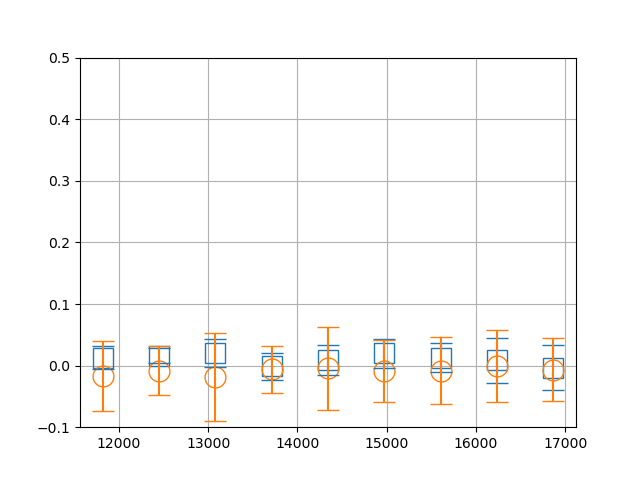

In [6]:
plot_displac(75,0.75)

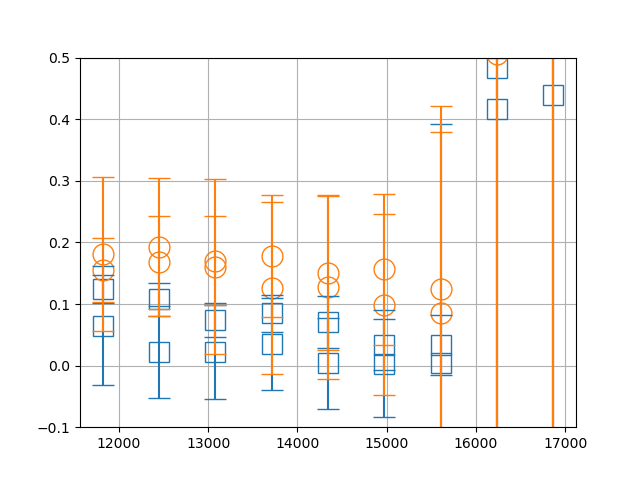

In [7]:
plot_displac(50,1.5)

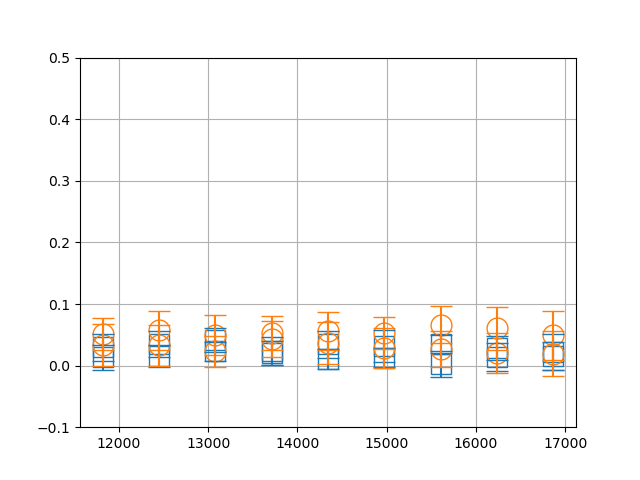

In [8]:
plot_displac(75,1.25)

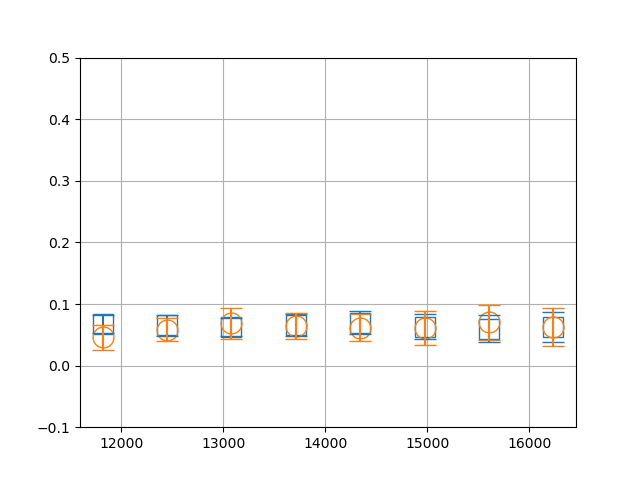

In [79]:
plot_displac(75,1.5)